In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:

#df_combined = None
for i in range(50, 75):
    csv_name = 'UNSW_2018_IoT_Botnet_Dataset_' + str(i) + '.csv'   
    csv_path = os.path.join('Entire Dataset', csv_name)
    df = pd.read_csv(csv_path, header=None)
    if df_combined is None:
        df_combined = df
    else:
        df_combined = pd.concat([df_combined, df], axis = 0, copy=False)
    
df_combined.head()

C:\Users\fran-\anaconda3\envs\DAA-socialdist-cuda11\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,1.526344e+09,e,arp,192.168.100.1,NaN,192.168.100.3,NaN,4,240,...,2,2,120,120,0.002508,0.000836,0.000836,0,Normal,Normal
1,2,1.526344e+09,e,tcp,192.168.100.7,139,192.168.100.4,36390,10,680,...,5,5,350,330,0.006190,0.002751,0.002751,0,Normal,Normal
2,3,1.526344e+09,e,udp,192.168.100.149,51838,27.124.125.250,123,2,180,...,1,1,90,90,20.590960,0.000000,0.000000,0,Normal,Normal
3,4,1.526344e+09,e,arp,192.168.100.4,NaN,192.168.100.7,NaN,10,510,...,5,5,210,300,0.006189,0.002751,0.002751,0,Normal,Normal
4,5,1.526344e+09,e,udp,192.168.100.27,58999,192.168.100.1,53,4,630,...,2,2,174,456,0.005264,0.001755,0.001755,0,Normal,Normal


In [6]:
df_combined.shape

(73370443, 35)

#### All the raw csv files contain the same amount of completely empty columns, these don't appear to just correspond to missing data but just full empty columns, removing these from the dataframe

In [9]:
nan_value = float("NaN")
df_combined.replace("", nan_value, inplace=True)

df_combined.dropna(how="all", axis=1, inplace=True)

df_combined.shape

(73370443, 29)

#### The final columns present are just the original network flow features, without the additional features generated across sliding window of length 100(Table 4 of paper) and without the mapping to numerical features(Section 7of paper)

In [10]:
column_names = ["pkSeqID","Stime","Flgs","Proto","Saddr","Sport","Daddr","Dport","Pkts","Bytes",
                "State","Ltime","Seq","Dur","Mean","Stddev","Sum","Min","Max","Spkts","Dpkts","Sbytes","Dbytes","Rate","Srate","Drate",
                "Attack","Category","Subcategory"]

len(column_names)

29

In [11]:
df_combined.columns = column_names
df_combined.head()

,pkSeqID,Stime,Flgs,Proto,Saddr,Sport,Daddr,Dport,Pkts,Bytes,...,Spkts,Dpkts,Sbytes,Dbytes,Rate,Srate,Drate,Attack,Category,Subcategory
0,1,1.526344e+09,e,arp,192.168.100.1,NaN,192.168.100.3,NaN,4,240,...,2,2,120,120,0.002508,0.000836,0.000836,0,Normal,Normal
1,2,1.526344e+09,e,tcp,192.168.100.7,139,192.168.100.4,36390,10,680,...,5,5,350,330,0.006190,0.002751,0.002751,0,Normal,Normal
2,3,1.526344e+09,e,udp,192.168.100.149,51838,27.124.125.250,123,2,180,...,1,1,90,90,20.590960,0.000000,0.000000,0,Normal,Normal
3,4,1.526344e+09,e,arp,192.168.100.4,NaN,192.168.100.7,NaN,10,510,...,5,5,210,300,0.006189,0.002751,0.002751,0,Normal,Normal
4,5,1.526344e+09,e,udp,192.168.100.27,58999,192.168.100.1,53,4,630,...,2,2,174,456,0.005264,0.001755,0.001755,0,Normal,Normal


#### As we can see belowthe entire dataset is just as imbalanced, so how to select subset? Should we use all normal network data to maximize amount of that class and then how much data altogether? 

In [12]:
df_combined.groupby(['Attack', 'Category', 'Subcategory']).size()

Attack  Category        Subcategory      
0       Normal          Normal                   9543
1       DDoS            HTTP                    19771
                        TCP                  19547603
                        UDP                  18965106
        DoS             HTTP                    29706
                        TCP                  12315997
                        UDP                  20659491
        Reconnaissance  OS_Fingerprint         358275
                        Service_Scan          1463364
        Theft           Data_Exfiltration         118
                        Keylogging               1469
dtype: int64

In [13]:
df_combined.groupby(['Attack', 'Category']).size()

Attack  Category      
0       Normal                9543
1       DDoS              38532480
        DoS               33005194
        Reconnaissance     1821639
        Theft                 1587
dtype: int64

In [14]:
df_combined.groupby(['Attack']).size()

Attack
0        9543
1    73360900
dtype: int64

#### As mentioned in paper source and destination port was occasionally missing for protocol arp, they mapped these missing values to negative one, doing the same for no.

In [15]:
#df_combined.replace(nan_value, -1, inplace=True)
df_combined['Sport'] = df_combined['Sport'].fillna(-1)
df_combined['Dport'] = df_combined['Dport'].fillna(-1)
df_combined.head()

,pkSeqID,Stime,Flgs,Proto,Saddr,Sport,Daddr,Dport,Pkts,Bytes,...,Spkts,Dpkts,Sbytes,Dbytes,Rate,Srate,Drate,Attack,Category,Subcategory
0,1,1.526344e+09,e,arp,192.168.100.1,-1,192.168.100.3,-1,4,240,...,2,2,120,120,0.002508,0.000836,0.000836,0,Normal,Normal
1,2,1.526344e+09,e,tcp,192.168.100.7,139,192.168.100.4,36390,10,680,...,5,5,350,330,0.006190,0.002751,0.002751,0,Normal,Normal
2,3,1.526344e+09,e,udp,192.168.100.149,51838,27.124.125.250,123,2,180,...,1,1,90,90,20.590960,0.000000,0.000000,0,Normal,Normal
3,4,1.526344e+09,e,arp,192.168.100.4,-1,192.168.100.7,-1,10,510,...,5,5,210,300,0.006189,0.002751,0.002751,0,Normal,Normal
4,5,1.526344e+09,e,udp,192.168.100.27,58999,192.168.100.1,53,4,630,...,2,2,174,456,0.005264,0.001755,0.001755,0,Normal,Normal


#### In the final dataset for the below paper the column flgs, proto and state have been mapped to numerical features - section 7 describes how state was mapped but not the other two but from a look at the other data seems they were just assigned some integer value

In [16]:
df_combined.dtypes

pkSeqID          int64
Stime          float64
Flgs            object
Proto           object
Saddr           object
Sport           object
Daddr           object
Dport           object
Pkts             int64
Bytes            int64
State           object
Ltime          float64
Seq              int64
Dur            float64
Mean           float64
Stddev         float64
Sum            float64
Min            float64
Max            float64
Spkts            int64
Dpkts            int64
Sbytes           int64
Dbytes           int64
Rate           float64
Srate          float64
Drate          float64
Attack           int64
Category        object
Subcategory     object
dtype: object

In [17]:
df_combined.groupby(['Flgs']).size()

Flgs
e         43954734
e    F          10
e   t           94
e  D             8
e &             56
e *          10635
e d           2234
e dD             1
e dS             2
e g        2733322
e r              5
e s       26087706
eU          581636
dtype: int64

In [18]:
df_combined.groupby(['Proto']).size()

Proto
arp              2830
icmp            32322
igmp                2
ipv6-icmp          88
rarp                1
tcp          33659883
udp          39675317
dtype: int64

In [19]:
df_combined.groupby(['State']).size()

State
ACC       17265
CLO           1
CON       10688
ECO        1381
FIN       50994
INT    39672083
MAS          64
NRS          88
PAR           4
REQ    21666023
RSP           3
RST    11920976
TST          64
URP       30809
dtype: int64

In [20]:
df_combined['Proto_number'] = df_combined.Proto.astype("category").cat.codes
df_combined['State_number'] = df_combined.State.astype("category").cat.codes
df_combined['Flgs_number'] = df_combined.Flgs.astype("category").cat.codes

df_combined.groupby(['Proto', 'Proto_number']).size()

Proto      Proto_number
arp        0                   2830
icmp       1                  32322
igmp       2                      2
ipv6-icmp  3                     88
rarp       4                      1
tcp        5               33659883
udp        6               39675317
dtype: int64

In [21]:
df_combined.groupby(['State', 'State_number']).size()

State  State_number
ACC    0                  17265
CLO    1                      1
CON    2                  10688
ECO    3                   1381
FIN    4                  50994
INT    5               39672083
MAS    6                     64
NRS    7                     88
PAR    8                      4
REQ    9               21666023
RSP    10                     3
RST    11              11920976
TST    12                    64
URP    13                 30809
dtype: int64

In [22]:
df_combined.groupby(['Flgs', 'Flgs_number']).size()

Flgs    Flgs_number
e       0              43954734
e    F  1                    10
e   t   2                    94
e  D    3                     8
e &     4                    56
e *     5                 10635
e d     6                  2234
e dD    7                     1
e dS    8                     2
e g     9               2733322
e r     10                    5
e s     11             26087706
eU      12               581636
dtype: int64

#### according to review and analysis paper icmp protocol has hexadecimal valus for Sport and Dport it recommends changing these to -1 

In [44]:
df_combined[df_combined['Proto']== 'icmp'].groupby(['Sport']).size()

Sport
0x0008     1381
0x000c        4
0x000d       64
0x0011       64
0x0303    30809
dtype: int64

In [45]:
df_combined[df_combined['Proto']== 'icmp'].groupby(['Dport']).size()

Dport
0x0000    132
0x0002     30
0x0004     31
0x0008     31
0x000e      1
         ... 
0xff0d      1
0xff44     29
0xff52     29
0xff78     32
0xffea      1
Length: 2443, dtype: int64

In [48]:
df_combined.loc[df_combined['Proto']== 'icmp', 'Sport'] = -1
df_combined[df_combined['Proto']== 'icmp'].groupby(['Sport']).size()

Sport
-1    32322
dtype: int64

In [49]:
df_combined.loc[df_combined['Proto']== 'icmp', 'Dport'] = -1
df_combined[df_combined['Proto']== 'icmp'].groupby(['Dport']).size()

Dport
-1    32322
dtype: int64

#### review and analysis paper section IV states that instances using ARP should have been labelled as normal traffic only and say these should be removed or relabled as normal. I don't fully understand this so I'm removing all arp instances

In [51]:
df_combined[df_combined['Proto']=='arp'].groupby(['Attack']).size()

Attack
0     468
1    2362
dtype: int64

In [52]:
df_combined.drop(df_combined.index[df_combined['Proto']=='arp'], inplace=True)

In [53]:
df_combined.shape

(73163327, 32)

pkSeqID         73163327
Stime           53429572
Flgs                  13
Proto                  6
Saddr                 27
Sport             131074
Daddr                293
Dport             113620
Pkts                1790
Bytes               6902
State                 13
Ltime           52157030
Seq               524327
Dur              8290075
Mean             3597147
Stddev           2125386
Sum              8503488
Min              2149670
Max              2600879
Spkts               1509
Dpkts                557
Sbytes              5374
Dbytes              2058
Rate              770976
Srate             644618
Drate             146338
Attack                 2
Category               5
Subcategory            8
Proto_number           6
State_number          13
Flgs_number           13
dtype: int64


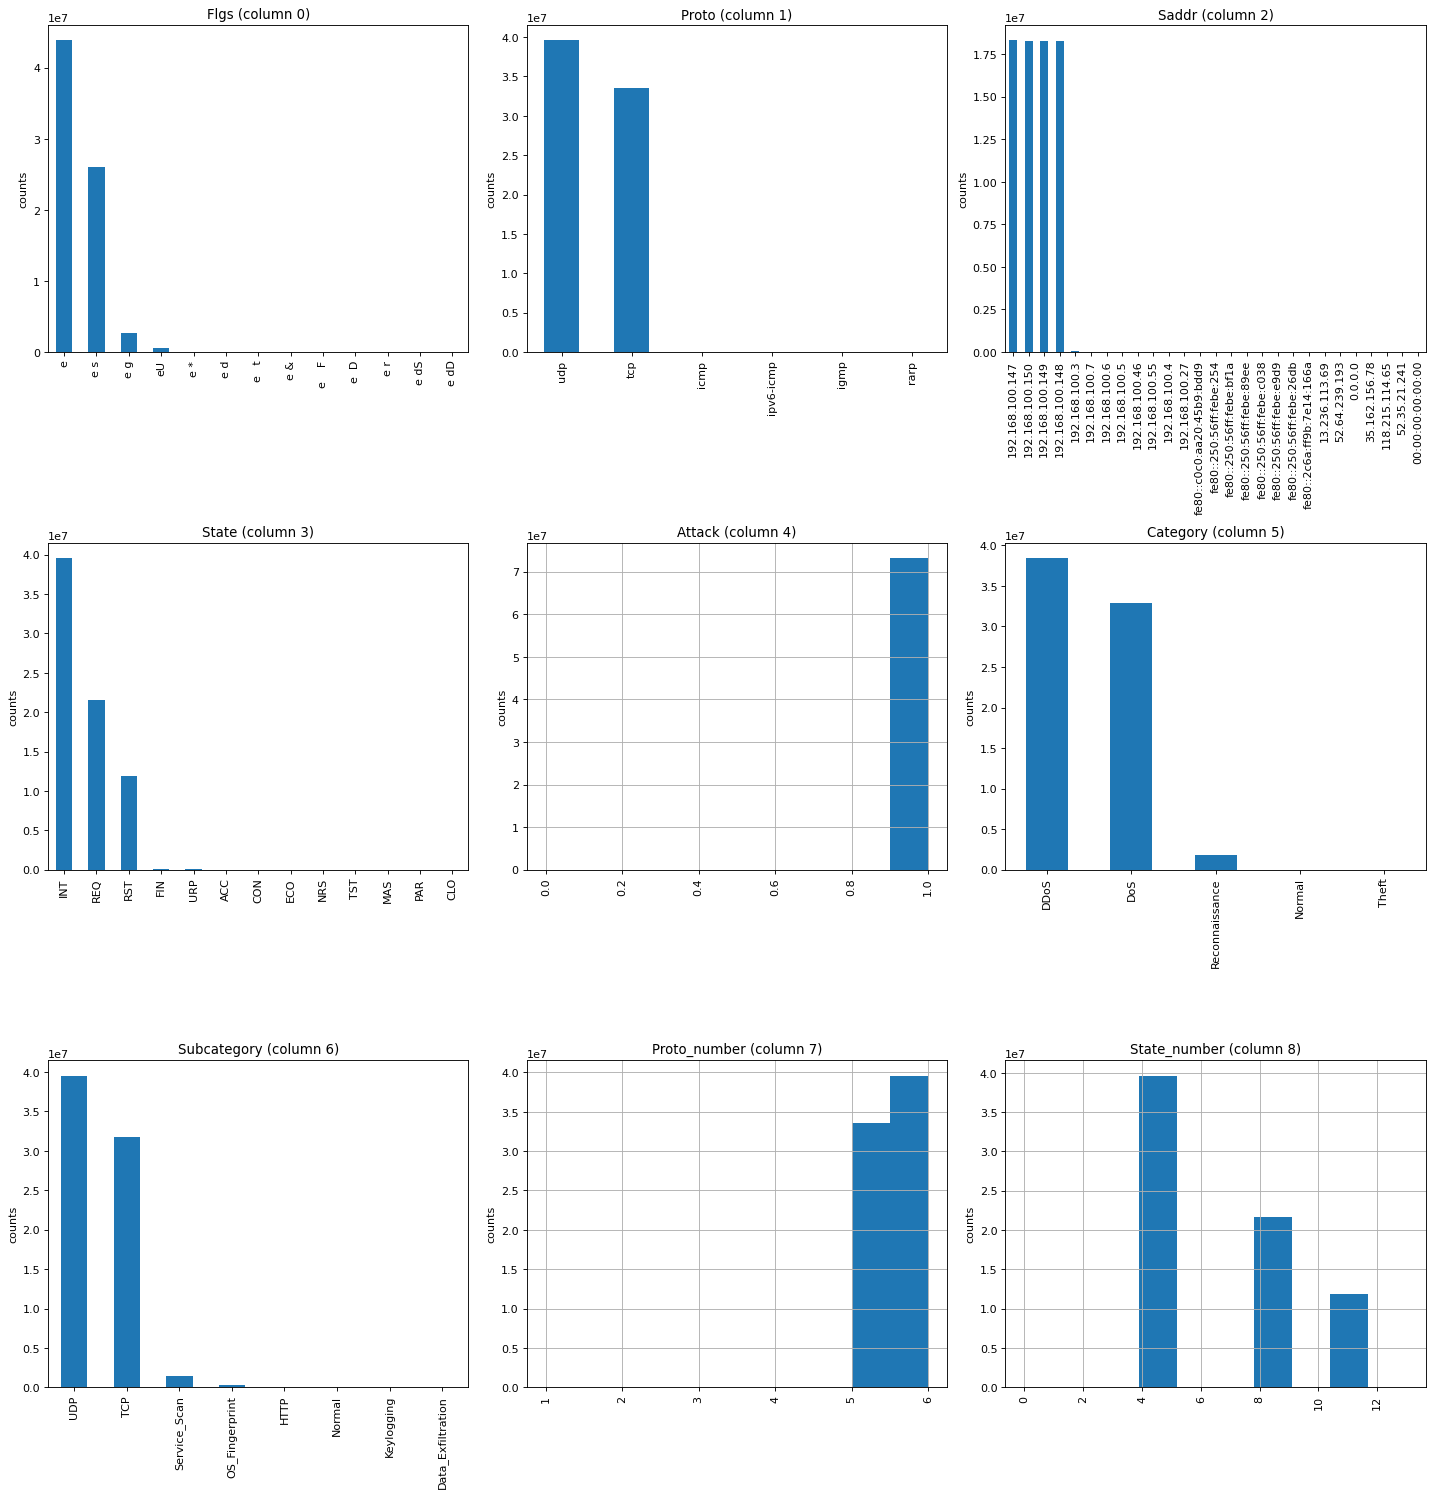

In [54]:
# Distribution graphs (histogram/bar graph) of column data (code from kaggle)
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    print(nunique)
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 6 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(int(nGraphRow), int(nGraphPerRow), i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

plotPerColumnDistribution(df_combined, 9, 3)

#### Downsampling large dataset to smaller subset, taking all normal and theft data

In [55]:
df_normal  = df_combined[df_combined['Attack'] == 0]
#df_combined = df_combined[df_combined['Attack']==1]
df_combined.drop(df_combined.index[df_combined['Attack']==0], inplace=True)
df_normal.shape

(9053, 32)

In [56]:
df_combined.shape

(72501723, 32)

In [57]:
df_theft = df_combined[df_combined['Category'] == 'Theft']
df_theft.shape

(1571, 32)

In [58]:
df_combined.drop(df_combined.index[df_combined['Category']=='Theft'], inplace=True)
df_combined.shape

(72387040, 32)

#### stratify the train, val, test splits

In [71]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

#shuffle
df_normal = df_normal.sample(frac=1)

train_normal, val_normal, test_normal = np.array_split(df_normal, [int(train_ratio*len(df_normal)), int((train_ratio + val_ratio)*len(df_normal))])
print(train_normal.shape)
print(val_normal.shape)
test_normal.shape

(5431, 32)
(1811, 32)


(1811, 32)

In [73]:
#clear memory
df_normal = []

df_theft = df_theft.sample(frac=1)

train_theft, val_theft, test_theft = np.array_split(df_theft, [int(train_ratio*len(df_theft)), int((train_ratio + val_ratio)*len(df_theft))])
print(train_theft.shape)
print(val_theft.shape)
test_theft.shape

(942, 32)
(314, 32)


(315, 32)

In [77]:
#clear memroy
df_theft = []

In [79]:
df_ds_train  = df_combined.groupby('Category', group_keys=False).apply(lambda df_combined: df_combined.sample(600000))
df_ds_train.groupby(['Category']).size()

Category
DDoS              600000
DoS               600000
Reconnaissance    600000
dtype: int64

In [80]:
df_ds_val  = df_combined.groupby('Category', group_keys=False).apply(lambda df_combined: df_combined.sample(200000))
df_ds_val.groupby(['Category']).size()

Category
DDoS              200000
DoS               200000
Reconnaissance    200000
dtype: int64

In [81]:
df_ds_test  = df_combined.groupby('Category', group_keys=False).apply(lambda df_combined: df_combined.sample(200000))
df_ds_test.groupby(['Category']).size()

Category
DDoS              200000
DoS               200000
Reconnaissance    200000
dtype: int64

In [82]:
final_train = pd.concat([df_ds_train, train_normal, train_theft], axis = 0, copy=False)
print(final_train.shape)
final_val = pd.concat([df_ds_val, val_normal, val_theft], axis=0, copy=False)
print(final_val.shape)
final_test = pd.concat([df_ds_test, test_normal, test_theft], axis=0, copy=False)
final_test.shape

(1806373, 32)
(602125, 32)


(602126, 32)

In [84]:
final_train.to_csv('botiot_wai_training.csv', index=False)
final_val.to_csv('botiot_wai_validation.csv', index=False)
final_test.to_csv('botiot_wai_testing.csv', index=False)